In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xg

from typing import Optional

import torch
from torch.utils.data import DataLoader, Dataset

import pytorch_lightning as pl
from transformers import AutoTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import wandb
from wandb.integration.xgboost import WandbCallback

from dataclasses import dataclass


/root/miniconda3/envs/lightning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
@dataclass
class BERTDataset(Dataset):
    def __init__(self, sentense1, sentense2, labels):
        super().__init__()
        self.sentense1 = sentense1
        self.sentense2 = sentense2

        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        sentense1_inputs = {"input_ids": self.sentense1["input_ids"][index], "attention_mask": self.sentense1["attention_mask"][index]}
        sentense2_inputs = {"input_ids": self.sentense2["input_ids"][index], "attention_mask": self.sentense2["attention_mask"][index]}

        return sentense1_inputs, sentense2_inputs
               

class BERTDatamodule(pl.LightningDataModule):
    def __init__(self, pred_file: str, tokenizer, max_len : int = 64, batch_size: int = 32, num_workers: int = 8):
        super().__init__()
        self.pred_file = pred_file
        self.tokenizer = tokenizer

        self.max_len = max_len
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.is_load_data = False

    def load_dataset(self):
        ## -- datafolder extension check -- ##
        if os.path.exists(self.pred_file) != False:
            self.load_data = pd.read_csv(self.pred_file, squeeze=True).to_dict('list')

            self.is_load_data = True

    def prepare_data(self):
        if not self.is_load_data:
            self.load_dataset()

        ## -- train dataset tokenize -- ##
        pred_sentense1 = self.tokenizer(self.load_data['sentence1'], padding='max_length', max_length=self.max_len, truncation=True, return_tensors="pt")
        pred_sentense2 = self.tokenizer(self.load_data['sentence2'], padding='max_length', max_length=self.max_len, truncation=True, return_tensors="pt")

        self.pred_dataset1 = {"input_ids": torch.tensor(pred_sentense1.input_ids),
                        "attention_mask": torch.tensor(pred_sentense1.attention_mask)}

        self.pred_dataset2 = {"input_ids": torch.tensor(pred_sentense2.input_ids),
                        "attention_mask": torch.tensor(pred_sentense2.attention_mask)}

        self.pred_labels = self.load_data['similarity_score']

    def setup(self, stage: Optional[str] = None) -> None:
        self.pred_dataset = BERTDataset(self.pred_dataset1, self.pred_dataset2, self.pred_labels)
            
    def test_dataloader(self):
        return DataLoader(self.pred_dataset, batch_size=self.batch_size, num_workers=self.num_workers)


class BERTpretrainingmodel(pl.LightningModule):
    def __init__(self, pretrained_model):
        super().__init__()
        self.model = pretrained_model
        self.preds = list()

    def forward(self, sentense1_input, sentense2_input):
        sentence1_output = self.model(sentense1_input["input_ids"], sentense1_input["attention_mask"]).last_hidden_state[:, 0]
        sentence2_output = self.model(sentense2_input["input_ids"], sentense2_input["attention_mask"]).last_hidden_state[:, 0]
        
        return sentence1_output, sentence2_output

    def test_step(self, batch, batch_idx):
        sentense1_input, sentense2_input = batch[:2]
        sentence1_output, sentence2_output = self(sentense1_input, sentense2_input)

        logits = torch.cat((sentence1_output, sentence2_output), axis=-1)
        return {'outputs': logits}

    def test_step_end(self, outputs):
        return {"outputs": outputs["outputs"]}

    def test_epoch_end(self, outputs):
        preds = torch.as_tensor(torch.cat([output['outputs'] for output in outputs], dim=0), dtype=torch.float16)
        self.preds = preds.detach().cpu().numpy().tolist()

In [4]:
def evaluate(predict, label):
    # evaluate prediction
    mae = mean_absolute_error(label, predict) 
    rmse = mean_squared_error(label, predict)
    print('MAE:', mae,'\tMSE: ', rmse)

In [5]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# set data to numpy format
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
pretrained_model = BertModel.from_pretrained("bert-base-uncased")

train_path = "./datasets/stsb_en_train.csv"
dm = BERTDatamodule(train_path, tokenizer)
dm.load_dataset()
model = BERTpretrainingmodel(pretrained_model)
model.eval()

trainer = pl.Trainer(devices="2,3",
                        accelerator='gpu',
                        strategy='dp')

trainer.test(model, datamodule=dm)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_111363/1500143227.py:35: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("c

Testing DataLoader 0: 100%|██████████| 180/180 [00:15<00:00, 11.66it/s]


[{}]

In [10]:
wandb.init(project="visualize-sts-model", name="xgboost")

train_input = model.preds
train_labels = dm.pred_labels

# train XGBoost model
train_input, valid_input, train_label, valid_label = train_test_split(train_input, train_labels, test_size=0.2)
xg_model = xg.XGBRegressor(n_estimators=1000, learning_rate=0.05, gamma=0, subsample=0.75,
                        colsample_bytree=1, max_depth=5)
xg_model.fit(train_input, train_label, eval_set=[(train_input, train_label), (valid_input, valid_label)], eval_metric='rmse', early_stopping_rounds=100, callbacks=[WandbCallback()])

best_iteration,▁
best_score,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_0-rmse,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_1-rmse,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_iteration,732
best_score,1.34879
epoch,831


/root/miniconda3/envs/lightning/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/root/miniconda3/envs/lightning/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/root/miniconda3/envs/lightning/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:2.48682	validation_1-rmse:2.57877
[1]	validation_0-rmse:2.39353	validation_1-rmse:2.49988
[2]	validation_0-rmse:2.30485	validation_1-rmse:2.42848
[3]	validation_0-rmse:2.21795	validation_1-rmse:2.35199
[4]	validation_0-rmse:2.14017	validation_1-rmse:2.29173
[5]	validation_0-rmse:2.06526	validation_1-rmse:2.23378
[6]	validation_0-rmse:1.99375	validation_1-rmse:2.18243
[7]	validation_0-rmse:1.92538	validation_1-rmse:2.13337
[8]	validation_0-rmse:1.86090	validation_1-rmse:2.09215
[9]	validation_0-rmse:1.80027	validation_1-rmse:2.04827
[10]	validation_0-rmse:1.74233	validation_1-rmse:2.00614
[11]	validation_0-rmse:1.68559	validation_1-rmse:1.96647
[12]	validation_0-rmse:1.63355	validation_1-rmse:1.93270
[13]	validation_0-rmse:1.58205	validation_1-rmse:1.90116
[14]	validation_0-rmse:1.53705	validation_1-rmse:1.87271
[15]	validation_0-rmse:1.49237	validation_1-rmse:1.84444
[16]	validation_0-rmse:1.45427	validation_1-rmse:1.82040
[17]	validation_0-rmse:1.41425	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [11]:
# predict test data and evaluate
test_path = "./datasets/stsb_en_test.csv"
dm = BERTDatamodule(test_path, tokenizer)
dm.load_dataset()
model = BERTpretrainingmodel(pretrained_model)

trainer = pl.Trainer(devices="2,3",
                        accelerator='gpu',
                        strategy='dp')
trainer.test(model, datamodule=dm)
test_input = model.preds
test_labels = dm.pred_labels

test_predict = xg_model.predict(test_input)

/tmp/ipykernel_111363/1500143227.py:35: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  self.load_data = pd.read_csv(self.pred_file, squeeze=True).to_dict('list')
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/tmp/ipykernel_111363/1500143227.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pred_dataset1 = {"input_ids": torch.tensor(pred_sentense1.input_ids),
/tmp/ipykernel_111363/1500143227.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor

Testing DataLoader 0: 100%|██████████| 44/44 [00:04<00:00, 10.32it/s]


In [13]:
evaluate(test_predict, test_labels)

submit = pd.read_csv('./results/sample_submission.csv')
submit['predict_score'] = test_predict
submit.to_csv('./results/submit_bert_xgb.csv', index=False)
print('Done.')

MAE: 0.5023410387065335 	MSE:  0.609204341152096
Done.


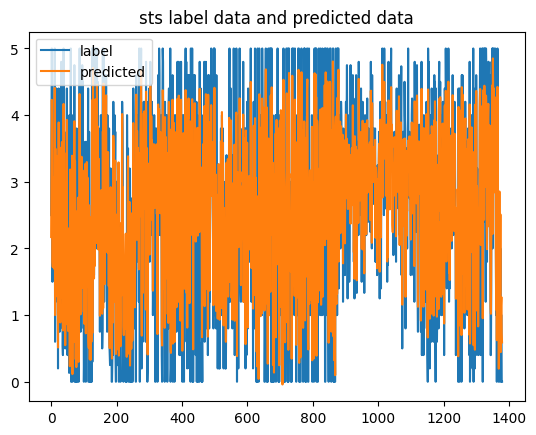

In [14]:
x_ax = range(len(test_labels))
plt.plot(x_ax, test_labels, label="label")
plt.plot(x_ax, test_predict, label="predicted")
plt.title("sts label data and predicted data")
plt.legend()
plt.show()